# DQN + A2C (CIFAR-10) integrated notebook

This notebook integrates the original DQN pipeline and an A2C implementation, adapts both to CIFAR-10 images (converted to 64x64 grayscale), trains a small autoencoder, then trains both RL algorithms on an ImageTransmission environment that simulates selecting latent truncation K for transmission.

Notes:
- Encoder and Decoder are defined inline (no external files).
- Default (nodest) hyperparameters are chosen to keep runtime reasonable. Change the hyperparameters in the top cell where marked for larger experiments.
- The notebook saves sample images and comparison plots to the working directory.


In [10]:
# Cell 1: imports and (changeable) hyperparameters - change values below for larger experiments
import os
import math
import random
from collections import deque, namedtuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision
import torchvision.transforms as T

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# ----------------- Change these for larger experiments -----------------
# Autoencoder training
AE_EPOCHS = 12            # nodest default; for serious run: try 50+
AE_BATCH = 128            # batch size for AE training
# RL training
DQN_EPISODES = 400        # nodest default; for serious run: try 1000+
A2C_EPISODES = 400        # nodest default; for serious run: try 1000+
STEPS_PER_EP = 50         # how many images per episode (short for demo)
# Preview / AE / RL sizes
CODE_DIM = 128            # must match encoder/decoder code_dim
N_PREV = 5                # number of previous latents used by decoder
PREVIEW_DIM = 16          # how many elements of z we expose as observation
K_CHOICES = [128, 96, 64, 32]
LAMBDA = 0.01             # penalty on K in reward
# DQN hyperparams
BATCH_SIZE = 64
GAMMA = 0.99
LR_DQN = 1e-3
REPLAY_CAP = 10000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.995
# A2C hyperparams
LR_A2C = 1e-3
N_STEPS = 10              # n-step bootstrap length; increase for performance
PRINT_INTERVAL = 20
SEED = 42
# ---------------------------------------------------------------------
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)


Device: cpu


In [2]:
# Cell 2: Inline Encoder and Decoder (integrated instead of separate files)
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_ch=1, code_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_ch, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.fc_enc = None
        self.code_dim = code_dim

    def forward(self, x):
        B = x.shape[0]
        feat = self.conv(x)
        if self.fc_enc is None:
            flat_dim = feat.numel() // B
            self.fc_enc = nn.Linear(flat_dim, self.code_dim).to(x.device)
            print(f"✅ Initialized fc_enc with input size {flat_dim}")
        flat = feat.reshape(B, -1)
        z = self.fc_enc(flat)
        return z

class Decoder(nn.Module):
    def __init__(self, code_dim=128, n_prev=5, output_ch=1):
        super().__init__()
        self.n_prev = n_prev
        self.code_dim = code_dim
        total_dim = (n_prev + 1) * code_dim

        self.fc_dec = nn.Linear(total_dim, 64 * 8 * 8)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, output_ch, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def decode(self, z, prev_latents=None):
        if prev_latents is not None:
            B = z.size(0)
            prev = prev_latents.view(B, self.n_prev * self.code_dim)
            z_cat = torch.cat([z, prev], dim=1)
        else:
            B = z.size(0)
            zeros = torch.zeros(B, self.n_prev * self.code_dim, device=z.device)
            z_cat = torch.cat([z, zeros], dim=1)

        feat = self.fc_dec(z_cat)
        feat = feat.view(-1, 64, 8, 8)
        rec = self.deconv(feat)
        return rec

    def forward(self, z, prev_latents=None):
        return self.decode(z, prev_latents)

# instantiate AE models
encoder = Encoder(input_ch=1, code_dim=CODE_DIM).to(DEVICE)
decoder = Decoder(code_dim=CODE_DIM, n_prev=N_PREV, output_ch=1).to(DEVICE)

# Print small sanity check
x = torch.randn(2,1,64,64, device=DEVICE)
with torch.no_grad():
    z = encoder(x)
    rec = decoder.decode(z, None)
print('AE forward shapes:', z.shape, rec.shape)


✅ Initialized fc_enc with input size 4096
AE forward shapes: torch.Size([2, 128]) torch.Size([2, 1, 64, 64])


In [3]:
# Cell 3: Load CIFAR-10, convert to grayscale 64x64, show sample grid
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid, save_image

transform = T.Compose([
    T.Resize((64,64)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=AE_BATCH, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=AE_BATCH, shuffle=False, num_workers=2)

# save first 25 test images grid (originals)
os.makedirs('outputs', exist_ok=True)
sample_imgs = []
for i, (img, lbl) in enumerate(testset):
    sample_imgs.append(img)
    if i >= 24:
        break
grid = make_grid(torch.stack(sample_imgs), nrow=5, pad_value=1.0)
save_image(grid, 'outputs/cifar10_test_25_originals.png')
print('Saved outputs/cifar10_test_25_originals.png')


100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


Saved outputs/cifar10_test_25_originals.png


In [4]:
# Cell 4: Train small autoencoder (MSE) - default modest epochs, change AE_EPOCHS above for longer training
ae_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
ae_loss_hist = []

for epoch in range(1, AE_EPOCHS+1):
    running = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        ae_optimizer.zero_grad()
        z = encoder(imgs)
        rec = decoder.decode(z, None)
        loss = F.mse_loss(rec, imgs)
        loss.backward()
        ae_optimizer.step()
        running += loss.item() * imgs.size(0)
    epoch_loss = running / len(trainset)
    ae_loss_hist.append(epoch_loss)
    print(f'AE Epoch {epoch}/{AE_EPOCHS} | loss = {epoch_loss:.6f}')

# save a reconstruction grid after AE training (full code)
encoder.eval(); decoder.eval()
with torch.no_grad():
    sample_batch = torch.stack(sample_imgs).to(DEVICE)
    z = encoder(sample_batch)
    rec_full = decoder.decode(z, None)
    grid_rec = make_grid(rec_full.cpu(), nrow=5, pad_value=1.0)
    save_image(grid_rec, 'outputs/cifar10_test_25_after_AE.png')
print('Saved outputs/cifar10_test_25_after_AE.png')
# also save AE models to disk (optional)
torch.save(encoder.state_dict(), 'outputs/encoder.pth')
torch.save(decoder.state_dict(), 'outputs/decoder.pth')
print('Saved AE weights to outputs/')


AE Epoch 1/12 | loss = 0.018159
AE Epoch 2/12 | loss = 0.005692
AE Epoch 3/12 | loss = 0.003624
AE Epoch 4/12 | loss = 0.002734
AE Epoch 5/12 | loss = 0.002317
AE Epoch 6/12 | loss = 0.002087
AE Epoch 7/12 | loss = 0.001969
AE Epoch 8/12 | loss = 0.001919
AE Epoch 9/12 | loss = 0.001883
AE Epoch 10/12 | loss = 0.001866
AE Epoch 11/12 | loss = 0.001852
AE Epoch 12/12 | loss = 0.001828
Saved outputs/cifar10_test_25_after_AE.png
Saved AE weights to outputs/


In [5]:
# Cell 5: ImageTransmissionEnv (uses trainset iterator)
class ImageTransmissionEnv:
    def __init__(self, dataset, encoder, decoder, device, preview_dim=PREVIEW_DIM, lambda_penalty=LAMBDA, max_steps=STEPS_PER_EP):
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.preview_dim = preview_dim
        self.lambda_penalty = lambda_penalty
        self.max_steps = max_steps
        self.length_levels = K_CHOICES
        self.idx = 0
        self.step_count = 0
        self.buffer = deque(maxlen=N_PREV)

    def reset(self):
        self.step_count = 0
        self.buffer.clear()
        # start from current idx image
        img, _ = self.dataset[self.idx]
        self.current_img = img.to(self.device).unsqueeze(0)
        with torch.no_grad():
            z = self.encoder(self.current_img)
        self.buffer.append(z.detach().cpu())
        obs = z[0, :self.preview_dim].cpu().numpy().astype(np.float32)
        return obs

    def step(self, action_idx):
        K = self.length_levels[int(action_idx)]
        with torch.no_grad():
            z = self.encoder(self.current_img)
        z_limited = z.clone()
        if K < z.shape[1]:
            z_limited[:, K:] = 0.0
        prev = None if len(self.buffer) < N_PREV else torch.cat(list(self.buffer), dim=0).unsqueeze(0).view(1, N_PREV, CODE_DIM).to(self.device)
        with torch.no_grad():
            rec = self.decoder.decode(z_limited.to(self.device), prev_latents=prev)
        mse = F.mse_loss(rec, self.current_img).item()
        psnr = 10.0 * math.log10(1.0 / (mse + 1e-8))
        penalty = self.lambda_penalty * (K / float(CODE_DIM))
        reward = psnr - penalty
        # advance to next image in dataset (circular)
        self.idx = (self.idx + 1) % len(self.dataset)
        img, _ = self.dataset[self.idx]
        self.current_img = img.to(self.device).unsqueeze(0)
        with torch.no_grad():
            z_next = self.encoder(self.current_img)
        self.buffer.append(z_next.detach().cpu())
        self.step_count += 1
        done = (self.step_count >= self.max_steps)
        obs = z_next[0, :self.preview_dim].cpu().numpy().astype(np.float32)
        return obs, float(reward), bool(done), {}

    def seed(self, s):
        random.seed(s); np.random.seed(s); torch.manual_seed(s)

env = ImageTransmissionEnv(trainset, encoder, decoder, DEVICE)
obs_dim = PREVIEW_DIM
n_actions = len(K_CHOICES)
print('Env obs_dim, n_actions =', obs_dim, n_actions)


Env obs_dim, n_actions = 16 4


In [11]:
# Cell 6: DQN (adapted to ImageTransmissionEnv)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_obs, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_obs, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x):
        return self.net(x)

policy_net = DQN(obs_dim, n_actions).to(DEVICE)
target_net = DQN(obs_dim, n_actions).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())
optimizer_dqn = optim.Adam(policy_net.parameters(), lr=LR_DQN)
memory = ReplayMemory(REPLAY_CAP)
steps_done = 0
dqn_reward_hist = []
dqn_length_hist = []
dqn_loss_hist = []

def select_action_dqn(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return int(policy_net(s).argmax(dim=1).item())
    else:
        return random.randrange(n_actions)

def optimize_model_dqn():
    if len(memory) < BATCH_SIZE:
        return None
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=DEVICE)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=DEVICE, dtype=torch.bool)
    non_final_next = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32, device=DEVICE) if any(non_final_mask) else None
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
    with torch.no_grad():
        if non_final_next is not None:
            next_state_values[non_final_mask] = target_net(non_final_next).max(1)[0].unsqueeze(1)
    expected_values = reward_batch + GAMMA * next_state_values
    loss = nn.SmoothL1Loss()(state_action_values, expected_values.detach())
    optimizer_dqn.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
    optimizer_dqn.step()
    return loss.item()

# DQN training loop (modest defaults)
for ep in range(1, DQN_EPISODES+1):
    obs = env.reset()
    total_reward = 0.0
    for t in range(STEPS_PER_EP):
        action = select_action_dqn(obs)
        next_obs, reward, done, info = env.step(action)
        memory.push(obs, action, None if done else next_obs, reward)
        obs = next_obs
        total_reward += reward
        l = optimize_model_dqn()
        if l is not None:
            dqn_loss_hist.append(l)
        # soft update
        for tp, pp in zip(target_net.parameters(), policy_net.parameters()):
            tp.data.copy_(TAU * pp.data + (1.0 - TAU) * tp.data)
        if done:
            break
    dqn_reward_hist.append(total_reward)
    dqn_length_hist.append(t+1)
    if ep % 20 == 0:
        print(f'DQN Episode {ep}/{DQN_EPISODES} | Reward: {total_reward:.2f} | avg(last20) = {np.mean(dqn_reward_hist[-20:]):.2f}')

torch.save(policy_net.state_dict(), 'outputs/dqn_policy.pth')
print('Saved outputs/dqn_policy.pth')


DQN Episode 20/400 | Reward: 1040.26 | avg(last20) = 1019.20
DQN Episode 40/400 | Reward: 1058.75 | avg(last20) = 1065.80
DQN Episode 60/400 | Reward: 1110.11 | avg(last20) = 1130.02
DQN Episode 80/400 | Reward: 1121.37 | avg(last20) = 1149.33
DQN Episode 100/400 | Reward: 1198.09 | avg(last20) = 1167.03
DQN Episode 120/400 | Reward: 1226.14 | avg(last20) = 1171.62
DQN Episode 140/400 | Reward: 1184.92 | avg(last20) = 1173.40
DQN Episode 160/400 | Reward: 1158.52 | avg(last20) = 1175.34
DQN Episode 180/400 | Reward: 1170.40 | avg(last20) = 1183.86
DQN Episode 200/400 | Reward: 1174.16 | avg(last20) = 1191.37
DQN Episode 220/400 | Reward: 1113.18 | avg(last20) = 1166.77
DQN Episode 240/400 | Reward: 1146.44 | avg(last20) = 1181.83
DQN Episode 260/400 | Reward: 1092.98 | avg(last20) = 1189.21
DQN Episode 280/400 | Reward: 1242.32 | avg(last20) = 1182.32
DQN Episode 300/400 | Reward: 1112.93 | avg(last20) = 1160.28
DQN Episode 320/400 | Reward: 1163.91 | avg(last20) = 1189.22
DQN Episode 

In [7]:
# Cell 7: A2C implementation (on same ImageTransmissionEnv)
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(128, n_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs=probs)
        return dist, value

    def forward(self, x):
        x = self.shared(x)
        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        probs = torch.softmax(logits, dim=-1)
        dist = Categorical(probs=probs)
        return dist, value

ac = ActorCritic(obs_dim, n_actions).to(DEVICE)
optimizer_ac = optim.Adam(ac.parameters(), lr=LR_A2C)

a2c_reward_hist = []
a2c_length_hist = []
a2c_loss_hist = []

# A2C training loop
for ep in range(1, A2C_EPISODES+1):
    obs = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
    total_reward = 0.0
    done = False
    step_in_ep = 0
    obs_buf = []
    logprob_buf = []
    value_buf = []
    reward_buf = []
    done_buf = []
    while not done and step_in_ep < STEPS_PER_EP:
        step_in_ep += 1
        dist, value = ac(obs.unsqueeze(0))
        action = dist.sample()
        log_prob = dist.log_prob(action)
        next_obs, reward, done, info = env.step(int(action.item()))
        obs_buf.append(obs)
        logprob_buf.append(log_prob.squeeze(0))
        value_buf.append(value.squeeze(0))
        reward_buf.append(reward)
        done_buf.append(float(done))
        total_reward += reward
        obs = torch.tensor(next_obs, dtype=torch.float32, device=DEVICE)
        if len(reward_buf) == N_STEPS or done:
            with torch.no_grad():
                if done:
                    next_value = torch.tensor(0.0, device=DEVICE)
                else:
                    _, nv = ac(obs.unsqueeze(0))
                    next_value = nv.squeeze(0)
            values = torch.stack(value_buf)
            log_probs = torch.stack(logprob_buf)
            rewards = torch.tensor(reward_buf, dtype=torch.float32, device=DEVICE)
            dones = torch.tensor(done_buf, dtype=torch.float32, device=DEVICE)
            T = rewards.shape[0]
            targets = torch.zeros(T, device=values.device)
            G = next_value
            for t in reversed(range(T)):
                G = rewards[t] + GAMMA * G * (1.0 - dones[t])
                targets[t] = G
            advantages = targets - values.detach()
            actor_loss = -(log_probs * advantages).mean()
            critic_loss = F.mse_loss(values, targets)
            loss = actor_loss + 0.5 * critic_loss
            optimizer_ac.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ac.parameters(), 5.0)
            optimizer_ac.step()
            a2c_loss_hist.append(loss.item())
            obs_buf.clear(); logprob_buf.clear(); value_buf.clear(); reward_buf.clear(); done_buf.clear()
    a2c_reward_hist.append(total_reward)
    a2c_length_hist.append(step_in_ep)
    if ep % PRINT_INTERVAL == 0:
        print(f'A2C Episode {ep}/{A2C_EPISODES} | avg(last{PRINT_INTERVAL}) = {np.mean(a2c_reward_hist[-PRINT_INTERVAL:]):.2f} | ep_len = {step_in_ep}')

torch.save(ac.state_dict(), 'outputs/a2c_ac.pth')
print('Saved outputs/a2c_ac.pth')


A2C Episode 20/400 | avg(last20) = 974.46 | ep_len = 50
A2C Episode 40/400 | avg(last20) = 973.07 | ep_len = 50
A2C Episode 60/400 | avg(last20) = 1083.79 | ep_len = 50
A2C Episode 80/400 | avg(last20) = 1179.64 | ep_len = 50
A2C Episode 100/400 | avg(last20) = 1221.44 | ep_len = 50
A2C Episode 120/400 | avg(last20) = 1206.24 | ep_len = 50
A2C Episode 140/400 | avg(last20) = 1244.12 | ep_len = 50
A2C Episode 160/400 | avg(last20) = 1250.55 | ep_len = 50
A2C Episode 180/400 | avg(last20) = 1253.23 | ep_len = 50
A2C Episode 200/400 | avg(last20) = 1256.49 | ep_len = 50
A2C Episode 220/400 | avg(last20) = 1260.42 | ep_len = 50
A2C Episode 240/400 | avg(last20) = 1262.68 | ep_len = 50
A2C Episode 260/400 | avg(last20) = 1258.54 | ep_len = 50
A2C Episode 280/400 | avg(last20) = 1256.66 | ep_len = 50
A2C Episode 300/400 | avg(last20) = 1267.02 | ep_len = 50
A2C Episode 320/400 | avg(last20) = 1260.62 | ep_len = 50
A2C Episode 340/400 | avg(last20) = 1262.42 | ep_len = 50
A2C Episode 360/400 

In [12]:
# Cell 8: Evaluate policies on the first 25 test images and save reconstructions; compute per-image MSEs
import torchvision.utils as vutils
encoder.eval(); decoder.eval(); policy_net.eval(); ac.eval()
sample_orig = torch.stack(sample_imgs).to(DEVICE)
# full AE reconstructions (already saved earlier)
with torch.no_grad():
    z_full = encoder(sample_orig)
    rec_full = decoder.decode(z_full, None)
# DQN reconstructions: use greedy policy (argmax) per sample
dqn_recons = []
dqn_ms = []
for i in range(sample_orig.size(0)):
    obs = z_full[i, :PREVIEW_DIM].cpu().numpy().astype(np.float32)
    s = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        act = int(policy_net(s).argmax(dim=1).item())
        K = K_CHOICES[act]
        z = encoder(sample_orig[i:i+1])
        z_l = z.clone()
        if K < z.shape[1]:
            z_l[:, K:] = 0.0
        rec = decoder.decode(z_l, None)
        dqn_recons.append(rec.squeeze(0).cpu())
        mse = F.mse_loss(rec, sample_orig[i:i+1]).item()
        dqn_ms.append(mse)
# A2C reconstructions: use greedy (argmax) of actor probs
a2c_recons = []
a2c_ms = []
for i in range(sample_orig.size(0)):
    obs = z_full[i, :PREVIEW_DIM].cpu().numpy().astype(np.float32)
    s = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        dist, _ = ac(s)
        act = int(dist.probs.argmax(dim=1).item())
        K = K_CHOICES[act]
        z = encoder(sample_orig[i:i+1])
        z_l = z.clone()
        if K < z.shape[1]:
            z_l[:, K:] = 0.0
        rec = decoder.decode(z_l, None)
        a2c_recons.append(rec.squeeze(0).cpu())
        mse = F.mse_loss(rec, sample_orig[i:i+1]).item()
        a2c_ms.append(mse)
# Save grids
grid_dqn = make_grid(torch.stack(dqn_recons), nrow=5, pad_value=1.0)
grid_a2c = make_grid(torch.stack(a2c_recons), nrow=5, pad_value=1.0)
save_image(grid_dqn, 'outputs/cifar10_test_25_after_DQN_policy.png')
save_image(grid_a2c, 'outputs/cifar10_test_25_after_A2C_policy.png')
print('Saved DQN/A2C reconstruction grids')
# compute and print MSEs
print('Mean MSE AE (full):', F.mse_loss(rec_full, sample_orig).item())
print('Mean MSE DQN:', np.mean(dqn_ms), 'Mean MSE A2C:', np.mean(a2c_ms))
# save per-image MSEs to CSV
import csv
with open('outputs/recon_mses.csv', 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['idx','mse_ae_full','mse_dqn','mse_a2c'])
    for i in range(sample_orig.size(0)):
        w.writerow([i, F.mse_loss(rec_full[i:i+1], sample_orig[i:i+1]).item(), dqn_ms[i], a2c_ms[i]])
print('Saved outputs/recon_mses.csv')


Saved DQN/A2C reconstruction grids
Mean MSE AE (full): 0.002051419345661998
Mean MSE DQN: 0.0020514191559050233 Mean MSE A2C: 0.0020514191559050233
Saved outputs/recon_mses.csv


Saved outputs/comparison_plots.png


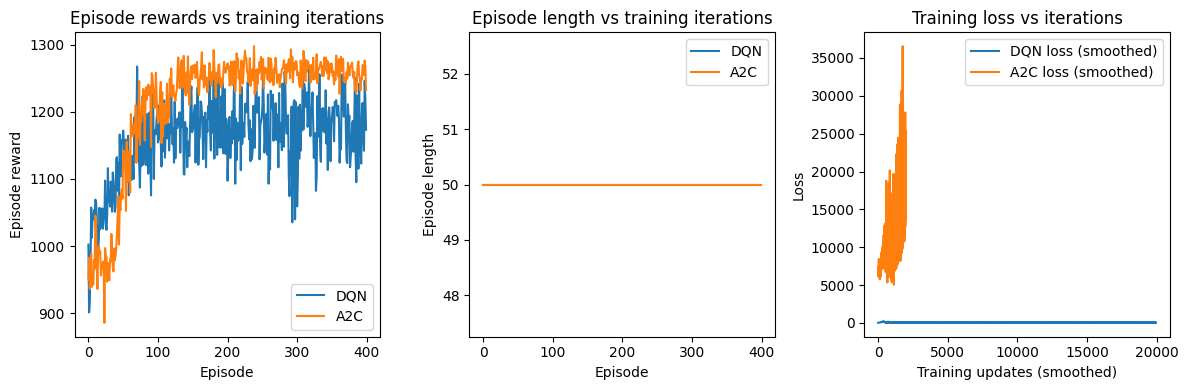

In [13]:
# Cell 9: Comparison plots (rewards, episode lengths, losses)
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)

plt.plot(dqn_reward_hist, label='DQN')
plt.plot(np.linspace(0, len(a2c_reward_hist)-1, len(dqn_reward_hist)), a2c_reward_hist[:len(dqn_reward_hist)], label='A2C')
plt.xlabel('Episode')
plt.ylabel('Episode reward')
plt.legend()
plt.title('Episode rewards vs training iterations')

plt.subplot(1,3,2)
plt.plot(dqn_length_hist, label='DQN')
plt.plot(np.linspace(0, len(a2c_length_hist)-1, len(dqn_length_hist)), a2c_length_hist[:len(dqn_length_hist)], label='A2C')
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.legend()
plt.title('Episode length vs training iterations')

plt.subplot(1,3,3)
# For losses align lengths by truncation/padding for display - use moving average smoothing
def smooth(x, w=5):
    if len(x) < w: return x
    return np.convolve(x, np.ones(w)/w, mode='valid')
sd = smooth(dqn_loss_hist, w=5) if len(dqn_loss_hist) > 0 else []
sa = smooth(a2c_loss_hist, w=5) if len(a2c_loss_hist) > 0 else []
if len(sd)>0: plt.plot(sd, label='DQN loss (smoothed)')
if len(sa)>0: plt.plot(sa, label='A2C loss (smoothed)')
plt.xlabel('Training updates (smoothed)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training loss vs iterations')

plt.tight_layout()
plt.savefig('outputs/comparison_plots.png')
print('Saved outputs/comparison_plots.png')
plt.show()


# Next steps and tuning


"To run a full experiment increase AE_EPOCHS (e.g., 50-200), DQN_EPISODES (e.g., 1000+), and A2C_EPISODES (e.g., 1000+).
Also increase STEPS_PER_EP if you want longer episodes (e.g., 200-400).
Use a GPU for practical runtimes.
"
